# Train transformer

In [1]:
import torch
import torch.nn as nn

from transformer_implementation import Transformer, Tokenizer, TransformerConfig, DataLoaderFactory
from utils import training_loop, plot_losses, estimate_loss

## Init
### Tokenizer

In [2]:
# init tokenizer
tokenizer = Tokenizer()

### Config

In [3]:
# init config
config = TransformerConfig(
    tokenizer,
    block_size = 256,
    batch_size = 12,
    n_layer = 6, # 6,
    n_head = 8,
    n_embd = 512,
    max_iters = 20000,
    eval_iters = 50,
    eval_interval = 500,
)
print(config)

TransformerConfig(
	self.tokenizer=<transformer_implementation.Tokenizer.Tokenizer object at 0x000001D919384F50>,
	self.block_size=256,
	self.batch_size=12,
	self.n_layer=3,
	self.n_head=8,
	self.n_embd=256,
	self.dropout=0.1,
	self.bias=False,
	self.device='cuda',
	self.learning_rate=0.0003,
	self.max_iters=20000,
	self.eval_interval=500,
	self.eval_iters=50,
	self.visualize=False,
)


### Loading dataset

In [4]:
# loading dataset
dataset = DataLoaderFactory(config.block_size, config.batch_size, tokenizer, config.device, 5000000)
len(dataset)

Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


Number of data by datasets splits
Train		: 5000000	-> 416666.6666666667
Validation	: 3000		-> 250.0
Test		: 3003		-> 250.25
Total		: 5006003


5006003

### Model

In [5]:
# Create model
model = Transformer(config)
model.train()
# Use nn.DataParallel to wrap the model.
# This will distribute the operations to multiple GPUs if they are available.
model = nn.DataParallel(model)
model = model.to(config.device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.98), eps=1e-9)

Number of Encoder parameters: 28.03M
number of Decoder parameters: 28.82M
Total number of parameters: 56.85M


## Training

### Loop

In [6]:
losses_list = training_loop(model, optimizer, dataset, config, saved_path = "./out/transformer-train.pth")

Train loss nan, Val loss nan, Saved nan:   0%|          | 0/20000 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\thiba\.virtualenvs\transformer-LWcVpt7F\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/50 [00:00<?, ?it/s]

### Plotting losses

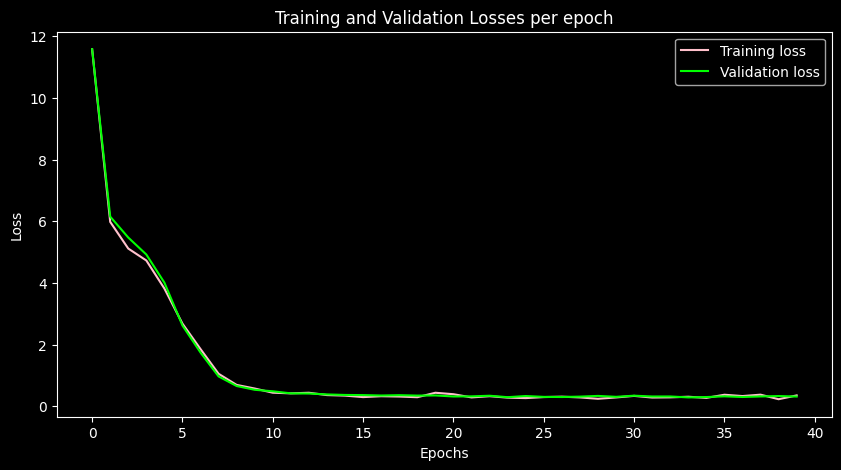

In [7]:
# Call the function
plot_losses(losses_list)

## Testing

In [8]:
test_loss = estimate_loss(model, dataset, config, ['test'])

Evaluation - test:   0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\thiba\.virtualenvs\transformer-LWcVpt7F\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [9]:
print(f"Test loss = {test_loss['test'].item():4f}")

Test loss = 0.334195


In [10]:
b = dataset.get_batch('val')
nb = next(b)

In [11]:
nb['inputs']

tensor([[100264,  15346,    279,  ..., 100266, 100266, 100266],
        [100264,   4071,    304,  ..., 100266, 100266, 100266],
        [100264,    644,   2144,  ..., 100266, 100266, 100266],
        ...,
        [100264,  33763,    690,  ..., 100266, 100266, 100266],
        [100264,  55519,   1603,  ..., 100266, 100266, 100266],
        [100264,    791,  22193,  ..., 100266, 100266, 100266]],
       device='cuda:0')

In [17]:
nb['translation']['en'][0]

'Should the judiciary be deprived of power?'

In [18]:
nb['translation']['fr'][0]

'Le pouvoir judiciaire sera-t-il renversé?'